In [1]:
# import packages
import os 
import pickle

import re
from datetime import datetime

import requests

import pytz

import pandas as pd
import numpy as np

import ast

import pyspark.sql.functions as F
from pyspark.sql.types import *
from pyspark.sql.functions import *


import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# import findspark
import findspark

# initialize findspark with spark directory

#ALWAYS HAVE TO BE CHANGED 
findspark.init("/Users/wouterdewitte/spark/")

# import pyspark
import pyspark
# create spark context
sc = pyspark.SparkContext()
# create spark session 
spark = pyspark.sql.SparkSession(sc)

22/11/21 16:53:30 WARN Utils: Your hostname, MacBook-Pro-van-Wouter.local resolves to a loopback address: 127.0.0.1, but we couldn't find any external IP address!
22/11/21 16:53:30 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/11/21 16:53:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
spark

In [4]:
#set this path to your path, for some reason I have an error 
#reading in all the files
import os 
path_json = ".././../data/Topic_vegan/*.json"

In [5]:
df_json = spark.read.json(path_json)

22/11/21 16:54:29 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [6]:
# select interesting features
import pyspark.sql.functions as F

df = df_json.select(F.col("user.name"),
                    F.col("user.screen_name"),
                    F.col("created_at"), 
                    F.col("full_text"),
                    F.col("entities.hashtags"),
                    F.col("lang"),
                    F.col("user.followers_count"),
                    F.col("user.friends_count"),
                    F.col("user.favourites_count"),
                    F.col("entities.urls"),
                    F.col("entities.symbols"),
                    F.col("retweet_count"),
                    F.col("favorite_count"))
df.limit(10).toPandas()

,name,screen_name,created_at,full_text,hashtags,lang,followers_count,friends_count,favourites_count,urls,symbols,retweet_count,favorite_count
0,のり/Nori,nori_k_629,Mon Apr 04 10:09:55 +0000 2022,RT @ohmpawatt: เพื่อนๆคิดถึงผมมั้ยยย ถ้าคิดถึง...,[],th,139,346,63382,[],[],3582,0
1,alice,myn4meizalize,Mon Apr 04 10:09:54 +0000 2022,RT @mynameisnanon: คิดถึงกันป่าว ถ้าคิดถึงต้อง...,[],th,655,194,8726,[],[],3837,0
2,Karen Reed 🌸,kandk670,Mon Apr 04 10:09:54 +0000 2022,@trudiebakescake Organic coconut oil in a jar ...,[],en,711,429,3420,[],[],0,0
3,ハル):),patlnwza55,Mon Apr 04 10:09:52 +0000 2022,RT @ohmpawatt: เพื่อนๆคิดถึงผมมั้ยยย ถ้าคิดถึง...,[],th,236,187,15655,[],[],3582,0
4,alice,myn4meizalize,Mon Apr 04 10:09:52 +0000 2022,RT @ohmpawatt: เพื่อนๆคิดถึงผมมั้ยยย ถ้าคิดถึง...,[],th,655,194,8726,[],[],3582,0
5,ﾌｧﾙﾄﾞﾗっ子organic有機💙💻,organic_yusai,Mon Apr 04 10:09:52 +0000 2022,マジでピンチ助けて自転車ガガガガ,[],ja,291,159,2886,[],[],0,1
6,のり/Nori,nori_k_629,Mon Apr 04 10:09:50 +0000 2022,RT @mynameisnanon: คิดถึงกันป่าว ถ้าคิดถึงต้อง...,[],th,139,346,63382,[],[],3837,0
7,｡◕‿◕｡𝑱𝒆 𝒕'𝒂𝒊𝒎𝒆 🐶🧡✨,MyFnlovely97,Mon Apr 04 10:09:50 +0000 2022,RT @ohmpawatt: เพื่อนๆคิดถึงผมมั้ยยย ถ้าคิดถึง...,[],th,245,213,31592,[],[],3582,0
8,Sang™,asan_gk,Mon Apr 04 10:09:50 +0000 2022,RT @NotechAna: Am I the only one who types in ...,[],en,2065,1926,5901,[],[],374,0
9,Trysia ):)▪︎never let me go▪︎,Winnie_thephuu,Mon Apr 04 10:09:48 +0000 2022,RT @ohmpawatt: เพื่อนๆคิดถึงผมมั้ยยย ถ้าคิดถึง...,[],th,379,460,18226,[],[],3582,0


In [7]:
# remove duplicates and retweets
df = df.filter(~F.col("full_text").startswith("RT")) \
                               .drop_duplicates() \
                               .cache()

In [8]:
# https://developer.twitter.com/en/docs/twitter-ads-api/timezones
# function to convert Twitter date string format
def getDate(date):
    if date is not None:
        return str(datetime.strptime(date,'%a %b %d %H:%M:%S +0000 %Y').replace(tzinfo=pytz.UTC).strftime("%Y-%m-%d %H:%M:%S"))
    else:
        return None

# UDF declaration
date_udf = F.udf(getDate, StringType())

# apply udf
df = df.withColumn('post_created_at', F.to_utc_timestamp(date_udf("created_at"), "UTC"))

In [9]:
# get first post
first_post = F.min('post_created_at').alias('earliest')
# get latest post
latest_post = F.max('post_created_at').alias('latest')
# show tweet period in our dataset
df.select(first_post, latest_post).show()

22/11/21 16:55:20 WARN MemoryStore: Not enough space to cache rdd_21_96 in memory! (computed 3.9 MiB so far)
22/11/21 16:55:20 WARN BlockManager: Persisting block rdd_21_96 to disk instead.
22/11/21 16:55:20 WARN MemoryStore: Not enough space to cache rdd_21_97 in memory! (computed 3.9 MiB so far)
22/11/21 16:55:20 WARN BlockManager: Persisting block rdd_21_97 to disk instead.
22/11/21 16:55:20 WARN MemoryStore: Not enough space to cache rdd_21_98 in memory! (computed 3.9 MiB so far)
22/11/21 16:55:20 WARN BlockManager: Persisting block rdd_21_98 to disk instead.


22/11/21 16:55:20 WARN MemoryStore: Not enough space to cache rdd_21_97 in memory! (computed 3.9 MiB so far)
22/11/21 16:55:20 WARN MemoryStore: Not enough space to cache rdd_21_99 in memory! (computed 3.9 MiB so far)
22/11/21 16:55:20 WARN BlockManager: Persisting block rdd_21_99 to disk instead.
22/11/21 16:55:20 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_21_102 in memory.
22/11/21 16:55:20 WARN MemoryStore: Not enough space to cache rdd_21_100 in memory! (computed 3.9 MiB so far)
22/11/21 16:55:20 WARN BlockManager: Persisting block rdd_21_100 to disk instead.
22/11/21 16:55:20 WARN MemoryStore: Not enough space to cache rdd_21_102 in memory! (computed 384.0 B so far)
22/11/21 16:55:20 WARN BlockManager: Persisting block rdd_21_102 to disk instead.


22/11/21 16:55:20 WARN MemoryStore: Not enough space to cache rdd_21_102 in memory! (computed 3.9 MiB so far)


22/11/21 16:55:22 WARN MemoryStore: Not enough space to cache rdd_21_106 in memory! (computed 3.9 MiB so far)
22/11/21 16:55:22 WARN BlockManager: Persisting block rdd_21_106 to disk instead.
22/11/21 16:55:22 WARN MemoryStore: Not enough space to cache rdd_21_106 in memory! (computed 3.9 MiB so far)
22/11/21 16:55:22 WARN MemoryStore: Not enough space to cache rdd_21_108 in memory! (computed 3.9 MiB so far)
22/11/21 16:55:22 WARN BlockManager: Persisting block rdd_21_108 to disk instead.


22/11/21 16:55:22 WARN MemoryStore: Not enough space to cache rdd_21_109 in memory! (computed 3.9 MiB so far)
22/11/21 16:55:22 WARN BlockManager: Persisting block rdd_21_109 to disk instead.
22/11/21 16:55:22 WARN MemoryStore: Not enough space to cache rdd_21_109 in memory! (computed 3.9 MiB so far)


22/11/21 16:55:24 WARN MemoryStore: Not enough space to cache rdd_21_114 in memory! (computed 3.9 MiB so far)
22/11/21 16:55:24 WARN BlockManager: Persisting block rdd_21_114 to disk instead.
22/11/21 16:55:24 WARN MemoryStore: Not enough space to cache rdd_21_114 in memory! (computed 3.9 MiB so far)
22/11/21 16:55:24 WARN MemoryStore: Not enough space to cache rdd_21_116 in memory! (computed 3.9 MiB so far)
22/11/21 16:55:24 WARN BlockManager: Persisting block rdd_21_116 to disk instead.
22/11/21 16:55:24 WARN MemoryStore: Not enough space to cache rdd_21_117 in memory! (computed 3.9 MiB so far)


22/11/21 16:55:24 WARN BlockManager: Persisting block rdd_21_117 to disk instead.


22/11/21 16:55:25 WARN MemoryStore: Not enough space to cache rdd_21_121 in memory! (computed 3.9 MiB so far)
22/11/21 16:55:25 WARN BlockManager: Persisting block rdd_21_121 to disk instead.


22/11/21 16:55:26 WARN MemoryStore: Not enough space to cache rdd_21_126 in memory! (computed 3.9 MiB so far)
22/11/21 16:55:26 WARN BlockManager: Persisting block rdd_21_126 to disk instead.
22/11/21 16:55:26 WARN MemoryStore: Not enough space to cache rdd_21_126 in memory! (computed 3.9 MiB so far)


22/11/21 16:55:27 WARN MemoryStore: Not enough space to cache rdd_21_129 in memory! (computed 3.9 MiB so far)
22/11/21 16:55:27 WARN BlockManager: Persisting block rdd_21_129 to disk instead.


22/11/21 16:55:27 WARN MemoryStore: Not enough space to cache rdd_21_133 in memory! (computed 3.9 MiB so far)
22/11/21 16:55:27 WARN BlockManager: Persisting block rdd_21_133 to disk instead.
22/11/21 16:55:28 WARN MemoryStore: Not enough space to cache rdd_21_135 in memory! (computed 3.9 MiB so far)
22/11/21 16:55:28 WARN BlockManager: Persisting block rdd_21_135 to disk instead.


22/11/21 16:55:29 WARN MemoryStore: Not enough space to cache rdd_21_136 in memory! (computed 3.9 MiB so far)
22/11/21 16:55:29 WARN BlockManager: Persisting block rdd_21_136 to disk instead.
22/11/21 16:55:29 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_21_139 in memory.
22/11/21 16:55:29 WARN MemoryStore: Not enough space to cache rdd_21_139 in memory! (computed 384.0 B so far)
22/11/21 16:55:29 WARN BlockManager: Persisting block rdd_21_139 to disk instead.


22/11/21 16:55:29 WARN MemoryStore: Not enough space to cache rdd_21_139 in memory! (computed 3.9 MiB so far)


22/11/21 16:55:29 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_21_142 in memory.
22/11/21 16:55:29 WARN MemoryStore: Not enough space to cache rdd_21_142 in memory! (computed 384.0 B so far)
22/11/21 16:55:29 WARN BlockManager: Persisting block rdd_21_142 to disk instead.


22/11/21 16:55:31 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_21_147 in memory.
22/11/21 16:55:31 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_21_148 in memory.
22/11/21 16:55:31 WARN MemoryStore: Not enough space to cache rdd_21_147 in memory! (computed 384.0 B so far)
22/11/21 16:55:31 WARN BlockManager: Persisting block rdd_21_147 to disk instead.
22/11/21 16:55:31 WARN MemoryStore: Not enough space to cache rdd_21_144 in memory! (computed 3.9 MiB so far)
22/11/21 16:55:31 WARN BlockManager: Persisting block rdd_21_144 to disk instead.
22/11/21 16:55:31 WARN MemoryStore: Not enough space to cache rdd_21_148 in memory! (computed 384.0 B so far)
22/11/21 16:55:31 WARN BlockManager: Persisting block rdd_21_148 to disk instead.


22/11/21 16:55:31 WARN MemoryStore: Not enough space to cache rdd_21_150 in memory! (computed 3.9 MiB so far)
22/11/21 16:55:31 WARN BlockManager: Persisting block rdd_21_150 to disk instead.
22/11/21 16:55:31 WARN MemoryStore: Not enough space to cache rdd_21_151 in memory! (computed 3.9 MiB so far)
22/11/21 16:55:31 WARN BlockManager: Persisting block rdd_21_151 to disk instead.


22/11/21 16:55:33 WARN MemoryStore: Not enough space to cache rdd_21_152 in memory! (computed 3.9 MiB so far)
22/11/21 16:55:33 WARN BlockManager: Persisting block rdd_21_152 to disk instead.
22/11/21 16:55:33 WARN MemoryStore: Not enough space to cache rdd_21_153 in memory! (computed 3.9 MiB so far)
22/11/21 16:55:33 WARN BlockManager: Persisting block rdd_21_153 to disk instead.
22/11/21 16:55:33 WARN MemoryStore: Not enough space to cache rdd_21_153 in memory! (computed 3.9 MiB so far)
22/11/21 16:55:33 WARN MemoryStore: Not enough space to cache rdd_21_154 in memory! (computed 3.9 MiB so far)
22/11/21 16:55:33 WARN BlockManager: Persisting block rdd_21_154 to disk instead.
22/11/21 16:55:33 WARN MemoryStore: Not enough space to cache rdd_21_156 in memory! (computed 3.9 MiB so far)
22/11/21 16:55:33 WARN BlockManager: Persisting block rdd_21_156 to disk instead.


22/11/21 16:55:33 WARN MemoryStore: Not enough space to cache rdd_21_156 in memory! (computed 3.9 MiB so far)
22/11/21 16:55:33 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_21_158 in memory.
22/11/21 16:55:33 WARN MemoryStore: Not enough space to cache rdd_21_158 in memory! (computed 384.0 B so far)
22/11/21 16:55:33 WARN BlockManager: Persisting block rdd_21_158 to disk instead.
22/11/21 16:55:33 WARN MemoryStore: Not enough space to cache rdd_21_157 in memory! (computed 3.9 MiB so far)
22/11/21 16:55:33 WARN BlockManager: Persisting block rdd_21_157 to disk instead.


22/11/21 16:55:34 WARN MemoryStore: Not enough space to cache rdd_21_160 in memory! (computed 3.9 MiB so far)
22/11/21 16:55:34 WARN BlockManager: Persisting block rdd_21_160 to disk instead.
22/11/21 16:55:34 WARN MemoryStore: Not enough space to cache rdd_21_161 in memory! (computed 3.9 MiB so far)
22/11/21 16:55:34 WARN BlockManager: Persisting block rdd_21_161 to disk instead.
22/11/21 16:55:34 WARN MemoryStore: Not enough space to cache rdd_21_161 in memory! (computed 3.9 MiB so far)
22/11/21 16:55:34 WARN MemoryStore: Not enough space to cache rdd_21_163 in memory! (computed 3.9 MiB so far)
22/11/21 16:55:34 WARN BlockManager: Persisting block rdd_21_163 to disk instead.


22/11/21 16:55:34 WARN MemoryStore: Not enough space to cache rdd_21_164 in memory! (computed 3.9 MiB so far)
22/11/21 16:55:34 WARN BlockManager: Persisting block rdd_21_164 to disk instead.
22/11/21 16:55:35 WARN MemoryStore: Not enough space to cache rdd_21_164 in memory! (computed 3.9 MiB so far)


22/11/21 16:55:36 WARN MemoryStore: Not enough space to cache rdd_21_168 in memory! (computed 3.9 MiB so far)
22/11/21 16:55:36 WARN BlockManager: Persisting block rdd_21_168 to disk instead.
22/11/21 16:55:36 WARN MemoryStore: Not enough space to cache rdd_21_169 in memory! (computed 3.9 MiB so far)
22/11/21 16:55:36 WARN BlockManager: Persisting block rdd_21_169 to disk instead.
22/11/21 16:55:36 WARN MemoryStore: Not enough space to cache rdd_21_169 in memory! (computed 3.9 MiB so far)


22/11/21 16:55:38 WARN MemoryStore: Not enough space to cache rdd_21_176 in memory! (computed 3.9 MiB so far)
22/11/21 16:55:38 WARN BlockManager: Persisting block rdd_21_176 to disk instead.
22/11/21 16:55:38 WARN MemoryStore: Not enough space to cache rdd_21_178 in memory! (computed 3.9 MiB so far)
22/11/21 16:55:38 WARN BlockManager: Persisting block rdd_21_178 to disk instead.
22/11/21 16:55:38 WARN MemoryStore: Not enough space to cache rdd_21_178 in memory! (computed 3.9 MiB so far)


22/11/21 16:55:39 WARN MemoryStore: Not enough space to cache rdd_21_182 in memory! (computed 3.9 MiB so far)
22/11/21 16:55:39 WARN BlockManager: Persisting block rdd_21_182 to disk instead.
22/11/21 16:55:39 WARN MemoryStore: Not enough space to cache rdd_21_183 in memory! (computed 3.9 MiB so far)
22/11/21 16:55:39 WARN BlockManager: Persisting block rdd_21_183 to disk instead.
22/11/21 16:55:39 WARN MemoryStore: Not enough space to cache rdd_21_183 in memory! (computed 3.9 MiB so far)


22/11/21 16:55:40 WARN MemoryStore: Not enough space to cache rdd_21_187 in memory! (computed 3.9 MiB so far)
22/11/21 16:55:40 WARN BlockManager: Persisting block rdd_21_187 to disk instead.
22/11/21 16:55:40 WARN MemoryStore: Not enough space to cache rdd_21_188 in memory! (computed 3.9 MiB so far)
22/11/21 16:55:40 WARN BlockManager: Persisting block rdd_21_188 to disk instead.
22/11/21 16:55:40 WARN MemoryStore: Not enough space to cache rdd_21_188 in memory! (computed 3.9 MiB so far)


22/11/21 16:55:40 WARN MemoryStore: Not enough space to cache rdd_21_189 in memory! (computed 3.9 MiB so far)
22/11/21 16:55:40 WARN BlockManager: Persisting block rdd_21_189 to disk instead.
22/11/21 16:55:40 WARN MemoryStore: Not enough space to cache rdd_21_190 in memory! (computed 3.9 MiB so far)
22/11/21 16:55:40 WARN BlockManager: Persisting block rdd_21_190 to disk instead.
22/11/21 16:55:40 WARN MemoryStore: Not enough space to cache rdd_21_190 in memory! (computed 3.9 MiB so far)


22/11/21 16:55:42 WARN MemoryStore: Not enough space to cache rdd_21_192 in memory! (computed 3.9 MiB so far)
22/11/21 16:55:42 WARN BlockManager: Persisting block rdd_21_192 to disk instead.
22/11/21 16:55:42 WARN MemoryStore: Not enough space to cache rdd_21_192 in memory! (computed 3.9 MiB so far)
22/11/21 16:55:42 WARN MemoryStore: Not enough space to cache rdd_21_195 in memory! (computed 3.9 MiB so far)
22/11/21 16:55:42 WARN BlockManager: Persisting block rdd_21_195 to disk instead.


+-------------------+-------------------+
|           earliest|             latest|
+-------------------+-------------------+
|2021-10-12 16:08:51|2022-10-11 23:17:33|
+-------------------+-------------------+



In [10]:
df.printSchema()

root
 |-- name: string (nullable = true)
 |-- screen_name: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- full_text: string (nullable = true)
 |-- hashtags: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- indices: array (nullable = true)
 |    |    |    |-- element: long (containsNull = true)
 |    |    |-- text: string (nullable = true)
 |-- lang: string (nullable = true)
 |-- followers_count: long (nullable = true)
 |-- friends_count: long (nullable = true)
 |-- favourites_count: long (nullable = true)
 |-- urls: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- display_url: string (nullable = true)
 |    |    |-- expanded_url: string (nullable = true)
 |    |    |-- indices: array (nullable = true)
 |    |    |    |-- element: long (containsNull = true)
 |    |    |-- url: string (nullable = true)
 |-- symbols: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 

# The evolution of tweet activity

Look at the frequency of tweets per month.

In [11]:
freq_month = df.withColumn('month', month('post_created_at'))

In [12]:
freq_month = freq_month.groupBy("month") \
                        .agg(countDistinct("full_text")) \
                        .withColumnRenamed("count(full_text)", "freq") \
                        .sort("month", ascending = True)

In [13]:
freq_month = freq_month.toPandas()

22/11/21 16:55:44 WARN MemoryStore: Not enough space to cache rdd_21_5 in memory! (computed 3.9 MiB so far)
22/11/21 16:55:44 WARN MemoryStore: Not enough space to cache rdd_21_6 in memory! (computed 3.9 MiB so far)
22/11/21 16:55:44 WARN MemoryStore: Not enough space to cache rdd_21_0 in memory! (computed 3.9 MiB so far)
22/11/21 16:55:44 WARN MemoryStore: Not enough space to cache rdd_21_2 in memory! (computed 3.9 MiB so far)
22/11/21 16:55:44 WARN MemoryStore: Not enough space to cache rdd_21_4 in memory! (computed 3.9 MiB so far)
22/11/21 16:55:44 WARN MemoryStore: Not enough space to cache rdd_21_7 in memory! (computed 3.9 MiB so far)


22/11/21 16:55:46 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_21_11 in memory.
22/11/21 16:55:46 WARN MemoryStore: Not enough space to cache rdd_21_11 in memory! (computed 384.0 B so far)


22/11/21 16:55:46 WARN MemoryStore: Not enough space to cache rdd_21_14 in memory! (computed 3.9 MiB so far)


22/11/21 16:55:48 WARN MemoryStore: Not enough space to cache rdd_21_18 in memory! (computed 3.9 MiB so far)
22/11/21 16:55:48 WARN MemoryStore: Not enough space to cache rdd_21_21 in memory! (computed 3.9 MiB so far)


22/11/21 16:55:49 WARN MemoryStore: Not enough space to cache rdd_21_28 in memory! (computed 3.9 MiB so far)
22/11/21 16:55:49 WARN MemoryStore: Not enough space to cache rdd_21_30 in memory! (computed 3.9 MiB so far)


22/11/21 16:55:51 WARN MemoryStore: Not enough space to cache rdd_21_36 in memory! (computed 3.9 MiB so far)
22/11/21 16:55:51 WARN MemoryStore: Not enough space to cache rdd_21_38 in memory! (computed 3.9 MiB so far)
22/11/21 16:55:51 WARN MemoryStore: Not enough space to cache rdd_21_37 in memory! (computed 3.9 MiB so far)


22/11/21 16:55:53 WARN MemoryStore: Not enough space to cache rdd_21_42 in memory! (computed 3.9 MiB so far)
22/11/21 16:55:53 WARN MemoryStore: Not enough space to cache rdd_21_44 in memory! (computed 3.9 MiB so far)
22/11/21 16:55:53 WARN MemoryStore: Not enough space to cache rdd_21_45 in memory! (computed 3.9 MiB so far)


22/11/21 16:55:55 WARN MemoryStore: Not enough space to cache rdd_21_50 in memory! (computed 3.9 MiB so far)


22/11/21 16:55:55 WARN MemoryStore: Not enough space to cache rdd_21_54 in memory! (computed 3.9 MiB so far)


22/11/21 16:55:57 WARN MemoryStore: Not enough space to cache rdd_21_58 in memory! (computed 3.9 MiB so far)


22/11/21 16:55:57 WARN MemoryStore: Not enough space to cache rdd_21_62 in memory! (computed 3.9 MiB so far)


22/11/21 16:55:58 WARN MemoryStore: Not enough space to cache rdd_21_65 in memory! (computed 3.9 MiB so far)


22/11/21 16:55:59 WARN MemoryStore: Not enough space to cache rdd_21_67 in memory! (computed 3.9 MiB so far)
22/11/21 16:55:59 WARN MemoryStore: Not enough space to cache rdd_21_70 in memory! (computed 3.9 MiB so far)
22/11/21 16:55:59 WARN MemoryStore: Not enough space to cache rdd_21_71 in memory! (computed 3.9 MiB so far)


22/11/21 16:56:00 WARN MemoryStore: Not enough space to cache rdd_21_74 in memory! (computed 3.9 MiB so far)


22/11/21 16:56:01 WARN MemoryStore: Not enough space to cache rdd_21_78 in memory! (computed 3.9 MiB so far)


22/11/21 16:56:01 WARN MemoryStore: Not enough space to cache rdd_21_79 in memory! (computed 3.9 MiB so far)


22/11/21 16:56:02 WARN MemoryStore: Not enough space to cache rdd_21_81 in memory! (computed 3.9 MiB so far)


22/11/21 16:56:02 WARN MemoryStore: Not enough space to cache rdd_21_83 in memory! (computed 3.9 MiB so far)
22/11/21 16:56:02 WARN MemoryStore: Not enough space to cache rdd_21_85 in memory! (computed 3.9 MiB so far)


22/11/21 16:56:02 WARN MemoryStore: Not enough space to cache rdd_21_86 in memory! (computed 3.9 MiB so far)
22/11/21 16:56:03 WARN MemoryStore: Not enough space to cache rdd_21_87 in memory! (computed 3.9 MiB so far)


22/11/21 16:56:04 WARN MemoryStore: Not enough space to cache rdd_21_90 in memory! (computed 3.9 MiB so far)


22/11/21 16:56:04 WARN MemoryStore: Not enough space to cache rdd_21_93 in memory! (computed 3.9 MiB so far)
22/11/21 16:56:04 WARN MemoryStore: Not enough space to cache rdd_21_94 in memory! (computed 3.9 MiB so far)
22/11/21 16:56:04 WARN MemoryStore: Not enough space to cache rdd_21_95 in memory! (computed 3.9 MiB so far)


22/11/21 16:56:05 WARN MemoryStore: Not enough space to cache rdd_21_98 in memory! (computed 3.9 MiB so far)


22/11/21 16:56:06 WARN MemoryStore: Not enough space to cache rdd_21_99 in memory! (computed 3.9 MiB so far)
22/11/21 16:56:06 WARN MemoryStore: Not enough space to cache rdd_21_102 in memory! (computed 3.9 MiB so far)


22/11/21 16:56:07 WARN MemoryStore: Not enough space to cache rdd_21_105 in memory! (computed 3.9 MiB so far)


22/11/21 16:56:08 WARN MemoryStore: Not enough space to cache rdd_21_109 in memory! (computed 3.9 MiB so far)
22/11/21 16:56:08 WARN MemoryStore: Not enough space to cache rdd_21_110 in memory! (computed 3.9 MiB so far)


22/11/21 16:56:09 WARN MemoryStore: Not enough space to cache rdd_21_114 in memory! (computed 3.9 MiB so far)


22/11/21 16:56:09 WARN MemoryStore: Not enough space to cache rdd_21_115 in memory! (computed 3.9 MiB so far)
22/11/21 16:56:09 WARN MemoryStore: Not enough space to cache rdd_21_117 in memory! (computed 3.9 MiB so far)


22/11/21 16:56:10 WARN MemoryStore: Not enough space to cache rdd_21_122 in memory! (computed 3.9 MiB so far)


22/11/21 16:56:11 WARN MemoryStore: Not enough space to cache rdd_21_125 in memory! (computed 3.9 MiB so far)
22/11/21 16:56:11 WARN MemoryStore: Not enough space to cache rdd_21_126 in memory! (computed 3.9 MiB so far)
22/11/21 16:56:11 WARN MemoryStore: Not enough space to cache rdd_21_127 in memory! (computed 3.9 MiB so far)


22/11/21 16:56:12 WARN MemoryStore: Not enough space to cache rdd_21_130 in memory! (computed 3.9 MiB so far)


22/11/21 16:56:13 WARN MemoryStore: Not enough space to cache rdd_21_134 in memory! (computed 3.9 MiB so far)
22/11/21 16:56:13 WARN MemoryStore: Not enough space to cache rdd_21_135 in memory! (computed 3.9 MiB so far)


22/11/21 16:56:14 WARN MemoryStore: Not enough space to cache rdd_21_138 in memory! (computed 3.9 MiB so far)


22/11/21 16:56:15 WARN MemoryStore: Not enough space to cache rdd_21_142 in memory! (computed 3.9 MiB so far)
22/11/21 16:56:15 WARN MemoryStore: Not enough space to cache rdd_21_143 in memory! (computed 3.9 MiB so far)


22/11/21 16:56:16 WARN MemoryStore: Not enough space to cache rdd_21_146 in memory! (computed 3.9 MiB so far)


22/11/21 16:56:16 WARN MemoryStore: Not enough space to cache rdd_21_147 in memory! (computed 3.9 MiB so far)
22/11/21 16:56:16 WARN MemoryStore: Not enough space to cache rdd_21_149 in memory! (computed 3.9 MiB so far)


22/11/21 16:56:16 WARN MemoryStore: Not enough space to cache rdd_21_150 in memory! (computed 3.9 MiB so far)
22/11/21 16:56:16 WARN MemoryStore: Not enough space to cache rdd_21_151 in memory! (computed 3.9 MiB so far)


22/11/21 16:56:18 WARN MemoryStore: Not enough space to cache rdd_21_154 in memory! (computed 3.9 MiB so far)


22/11/21 16:56:18 WARN MemoryStore: Not enough space to cache rdd_21_155 in memory! (computed 3.9 MiB so far)


22/11/21 16:56:18 WARN MemoryStore: Not enough space to cache rdd_21_158 in memory! (computed 3.9 MiB so far)
22/11/21 16:56:18 WARN MemoryStore: Not enough space to cache rdd_21_159 in memory! (computed 3.9 MiB so far)


22/11/21 16:56:19 WARN MemoryStore: Not enough space to cache rdd_21_161 in memory! (computed 3.9 MiB so far)


22/11/21 16:56:20 WARN MemoryStore: Not enough space to cache rdd_21_165 in memory! (computed 3.9 MiB so far)
22/11/21 16:56:20 WARN MemoryStore: Not enough space to cache rdd_21_167 in memory! (computed 3.9 MiB so far)


22/11/21 16:56:21 WARN MemoryStore: Not enough space to cache rdd_21_169 in memory! (computed 3.9 MiB so far)


22/11/21 16:56:21 WARN MemoryStore: Not enough space to cache rdd_21_171 in memory! (computed 3.9 MiB so far)
22/11/21 16:56:21 WARN MemoryStore: Not enough space to cache rdd_21_172 in memory! (computed 3.9 MiB so far)


22/11/21 16:56:22 WARN MemoryStore: Not enough space to cache rdd_21_175 in memory! (computed 3.9 MiB so far)


22/11/21 16:56:22 WARN MemoryStore: Not enough space to cache rdd_21_176 in memory! (computed 3.9 MiB so far)


22/11/21 16:56:23 WARN MemoryStore: Not enough space to cache rdd_21_177 in memory! (computed 3.9 MiB so far)
22/11/21 16:56:23 WARN MemoryStore: Not enough space to cache rdd_21_179 in memory! (computed 3.9 MiB so far)


22/11/21 16:56:23 WARN MemoryStore: Not enough space to cache rdd_21_180 in memory! (computed 3.9 MiB so far)


22/11/21 16:56:23 WARN MemoryStore: Not enough space to cache rdd_21_183 in memory! (computed 3.9 MiB so far)
22/11/21 16:56:24 WARN MemoryStore: Not enough space to cache rdd_21_184 in memory! (computed 3.9 MiB so far)


22/11/21 16:56:24 WARN MemoryStore: Not enough space to cache rdd_21_185 in memory! (computed 3.9 MiB so far)


22/11/21 16:56:25 WARN MemoryStore: Not enough space to cache rdd_21_187 in memory! (computed 3.9 MiB so far)


22/11/21 16:56:25 WARN MemoryStore: Not enough space to cache rdd_21_190 in memory! (computed 3.9 MiB so far)
22/11/21 16:56:25 WARN MemoryStore: Not enough space to cache rdd_21_191 in memory! (computed 3.9 MiB so far)


22/11/21 16:56:26 WARN MemoryStore: Not enough space to cache rdd_21_192 in memory! (computed 3.9 MiB so far)


22/11/21 16:56:26 WARN MemoryStore: Not enough space to cache rdd_21_193 in memory! (computed 3.9 MiB so far)


22/11/21 16:56:27 WARN MemoryStore: Not enough space to cache rdd_21_196 in memory! (computed 3.9 MiB so far)


22/11/21 16:56:27 WARN MemoryStore: Not enough space to cache rdd_21_199 in memory! (computed 3.9 MiB so far)


22/11/21 16:56:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/11/21 16:56:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/11/21 16:56:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/11/21 16:56:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/11/21 16:56:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/11/21 16:56:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/11/21 16:56:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/11/21 16:56:29 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/11/21 16:56:29 WARN RowBasedKeyValueBatch: Calling spill() on

<AxesSubplot:xlabel='month'>

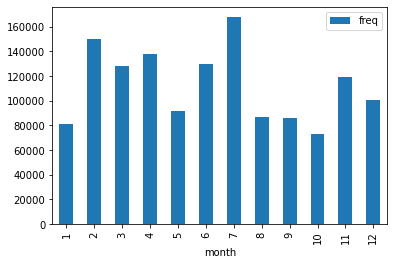

In [14]:
freq_month.plot.bar(x='month', y='freq') 

Look at the frequency of tweets per week.

In [15]:
freq_week = df.withColumn('week', weekofyear('post_created_at'))

In [16]:
freq_week = freq_week.groupBy("week") \
                        .agg(countDistinct("full_text")) \
                        .withColumnRenamed("count(full_text)", "freq") \
                        .sort("week", ascending = True)

In [17]:
freq_week = freq_week.toPandas()

22/11/21 16:56:40 WARN MemoryStore: Not enough space to cache rdd_21_47 in memory! (computed 3.9 MiB so far)


22/11/21 16:56:42 WARN MemoryStore: Not enough space to cache rdd_21_54 in memory! (computed 3.9 MiB so far)
22/11/21 16:56:42 WARN MemoryStore: Not enough space to cache rdd_21_53 in memory! (computed 3.9 MiB so far)


22/11/21 16:56:43 WARN MemoryStore: Not enough space to cache rdd_21_57 in memory! (computed 3.9 MiB so far)
22/11/21 16:56:43 WARN MemoryStore: Not enough space to cache rdd_21_59 in memory! (computed 3.9 MiB so far)


22/11/21 16:56:43 WARN MemoryStore: Not enough space to cache rdd_21_61 in memory! (computed 3.9 MiB so far)
22/11/21 16:56:44 WARN MemoryStore: Not enough space to cache rdd_21_63 in memory! (computed 3.9 MiB so far)


22/11/21 16:56:45 WARN MemoryStore: Not enough space to cache rdd_21_66 in memory! (computed 3.9 MiB so far)
22/11/21 16:56:45 WARN MemoryStore: Not enough space to cache rdd_21_67 in memory! (computed 3.9 MiB so far)
22/11/21 16:56:45 WARN MemoryStore: Not enough space to cache rdd_21_69 in memory! (computed 3.9 MiB so far)
22/11/21 16:56:45 WARN MemoryStore: Not enough space to cache rdd_21_71 in memory! (computed 3.9 MiB so far)


22/11/21 16:56:47 WARN MemoryStore: Not enough space to cache rdd_21_74 in memory! (computed 3.9 MiB so far)
22/11/21 16:56:47 WARN MemoryStore: Not enough space to cache rdd_21_76 in memory! (computed 3.9 MiB so far)
22/11/21 16:56:47 WARN MemoryStore: Not enough space to cache rdd_21_77 in memory! (computed 3.9 MiB so far)


22/11/21 16:56:48 WARN MemoryStore: Not enough space to cache rdd_21_81 in memory! (computed 3.9 MiB so far)


22/11/21 16:56:49 WARN MemoryStore: Not enough space to cache rdd_21_84 in memory! (computed 3.9 MiB so far)
22/11/21 16:56:49 WARN MemoryStore: Not enough space to cache rdd_21_85 in memory! (computed 3.9 MiB so far)


22/11/21 16:56:49 WARN MemoryStore: Not enough space to cache rdd_21_87 in memory! (computed 3.9 MiB so far)
22/11/21 16:56:50 WARN MemoryStore: Not enough space to cache rdd_21_89 in memory! (computed 3.9 MiB so far)
22/11/21 16:56:50 WARN MemoryStore: Not enough space to cache rdd_21_92 in memory! (computed 3.9 MiB so far)


22/11/21 16:56:51 WARN MemoryStore: Not enough space to cache rdd_21_95 in memory! (computed 3.9 MiB so far)
22/11/21 16:56:52 WARN MemoryStore: Not enough space to cache rdd_21_97 in memory! (computed 3.9 MiB so far)


22/11/21 16:56:52 WARN MemoryStore: Not enough space to cache rdd_21_100 in memory! (computed 3.9 MiB so far)
22/11/21 16:56:52 WARN MemoryStore: Not enough space to cache rdd_21_101 in memory! (computed 3.9 MiB so far)


22/11/21 16:56:53 WARN MemoryStore: Not enough space to cache rdd_21_103 in memory! (computed 3.9 MiB so far)


22/11/21 16:56:54 WARN MemoryStore: Not enough space to cache rdd_21_105 in memory! (computed 3.9 MiB so far)


22/11/21 16:56:54 WARN MemoryStore: Not enough space to cache rdd_21_108 in memory! (computed 3.9 MiB so far)


22/11/21 16:56:54 WARN MemoryStore: Not enough space to cache rdd_21_110 in memory! (computed 3.9 MiB so far)
22/11/21 16:56:54 WARN MemoryStore: Not enough space to cache rdd_21_111 in memory! (computed 3.9 MiB so far)


22/11/21 16:56:56 WARN MemoryStore: Not enough space to cache rdd_21_114 in memory! (computed 3.9 MiB so far)
22/11/21 16:56:56 WARN MemoryStore: Not enough space to cache rdd_21_117 in memory! (computed 3.9 MiB so far)


22/11/21 16:56:56 WARN MemoryStore: Not enough space to cache rdd_21_119 in memory! (computed 3.9 MiB so far)


22/11/21 16:56:57 WARN MemoryStore: Not enough space to cache rdd_21_123 in memory! (computed 3.9 MiB so far)


22/11/21 16:56:58 WARN MemoryStore: Not enough space to cache rdd_21_125 in memory! (computed 3.9 MiB so far)


22/11/21 16:56:58 WARN MemoryStore: Not enough space to cache rdd_21_127 in memory! (computed 3.9 MiB so far)


22/11/21 16:56:59 WARN MemoryStore: Not enough space to cache rdd_21_130 in memory! (computed 3.9 MiB so far)
22/11/21 16:56:59 WARN MemoryStore: Not enough space to cache rdd_21_131 in memory! (computed 3.9 MiB so far)
22/11/21 16:57:00 WARN MemoryStore: Not enough space to cache rdd_21_133 in memory! (computed 3.9 MiB so far)
22/11/21 16:57:00 WARN MemoryStore: Not enough space to cache rdd_21_135 in memory! (computed 3.9 MiB so far)


22/11/21 16:57:01 WARN MemoryStore: Not enough space to cache rdd_21_137 in memory! (computed 3.9 MiB so far)


22/11/21 16:57:01 WARN MemoryStore: Not enough space to cache rdd_21_141 in memory! (computed 3.9 MiB so far)
22/11/21 16:57:01 WARN MemoryStore: Not enough space to cache rdd_21_143 in memory! (computed 3.9 MiB so far)


22/11/21 16:57:03 WARN MemoryStore: Not enough space to cache rdd_21_145 in memory! (computed 3.9 MiB so far)


22/11/21 16:57:03 WARN MemoryStore: Not enough space to cache rdd_21_148 in memory! (computed 3.9 MiB so far)
22/11/21 16:57:03 WARN MemoryStore: Not enough space to cache rdd_21_150 in memory! (computed 3.9 MiB so far)


22/11/21 16:57:04 WARN MemoryStore: Not enough space to cache rdd_21_153 in memory! (computed 3.9 MiB so far)
22/11/21 16:57:05 WARN MemoryStore: Not enough space to cache rdd_21_155 in memory! (computed 3.9 MiB so far)


22/11/21 16:57:05 WARN MemoryStore: Not enough space to cache rdd_21_159 in memory! (computed 3.9 MiB so far)


22/11/21 16:57:06 WARN MemoryStore: Not enough space to cache rdd_21_161 in memory! (computed 3.9 MiB so far)


22/11/21 16:57:06 WARN MemoryStore: Not enough space to cache rdd_21_164 in memory! (computed 3.9 MiB so far)


22/11/21 16:57:07 WARN MemoryStore: Not enough space to cache rdd_21_167 in memory! (computed 3.9 MiB so far)


22/11/21 16:57:08 WARN MemoryStore: Not enough space to cache rdd_21_170 in memory! (computed 3.9 MiB so far)
22/11/21 16:57:09 WARN MemoryStore: Not enough space to cache rdd_21_175 in memory! (computed 3.9 MiB so far)


22/11/21 16:57:10 WARN MemoryStore: Not enough space to cache rdd_21_177 in memory! (computed 3.9 MiB so far)


22/11/21 16:57:10 WARN MemoryStore: Not enough space to cache rdd_21_182 in memory! (computed 3.9 MiB so far)
22/11/21 16:57:10 WARN MemoryStore: Not enough space to cache rdd_21_183 in memory! (computed 3.9 MiB so far)


22/11/21 16:57:11 WARN MemoryStore: Not enough space to cache rdd_21_185 in memory! (computed 3.9 MiB so far)


22/11/21 16:57:12 WARN MemoryStore: Not enough space to cache rdd_21_190 in memory! (computed 3.9 MiB so far)


22/11/21 16:57:13 WARN MemoryStore: Not enough space to cache rdd_21_193 in memory! (computed 3.9 MiB so far)


22/11/21 16:57:14 WARN MemoryStore: Not enough space to cache rdd_21_198 in memory! (computed 3.9 MiB so far)
22/11/21 16:57:14 WARN MemoryStore: Not enough space to cache rdd_21_199 in memory! (computed 3.9 MiB so far)


22/11/21 16:57:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/11/21 16:57:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/11/21 16:57:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/11/21 16:57:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/11/21 16:57:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/11/21 16:57:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/11/21 16:57:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/11/21 16:57:15 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/11/21 16:57:15 WARN RowBasedKeyValueBatch: Calling spill() on

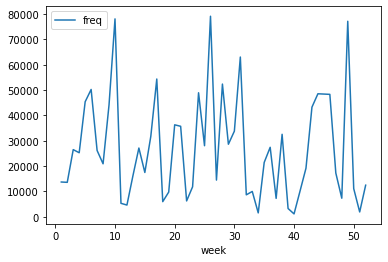

In [18]:
freq_week.plot.line(x='week', y='freq') 
plt.show()

# The evolution of tweet engagement 

In [19]:
eng_weekly = df.withColumn('week', weekofyear('post_created_at'))

In [20]:
eng_weekly = eng_weekly.groupBy("week") \
                        .agg(sum("retweet_count").alias("retweets"), sum("favorite_count").alias("favorites")) \
                        .sort("week", ascending = True)

In [21]:
eng_weekly.show()

22/11/21 16:57:25 WARN MemoryStore: Not enough space to cache rdd_21_44 in memory! (computed 3.9 MiB so far)
22/11/21 16:57:25 WARN MemoryStore: Not enough space to cache rdd_21_46 in memory! (computed 3.9 MiB so far)


22/11/21 16:57:27 WARN MemoryStore: Not enough space to cache rdd_21_50 in memory! (computed 3.9 MiB so far)
22/11/21 16:57:27 WARN MemoryStore: Not enough space to cache rdd_21_54 in memory! (computed 3.9 MiB so far)


22/11/21 16:57:28 WARN MemoryStore: Not enough space to cache rdd_21_58 in memory! (computed 3.9 MiB so far)
22/11/21 16:57:29 WARN MemoryStore: Not enough space to cache rdd_21_61 in memory! (computed 3.9 MiB so far)
22/11/21 16:57:29 WARN MemoryStore: Not enough space to cache rdd_21_62 in memory! (computed 3.9 MiB so far)


22/11/21 16:57:33 WARN MemoryStore: Not enough space to cache rdd_21_81 in memory! (computed 3.9 MiB so far)


22/11/21 16:57:34 WARN MemoryStore: Not enough space to cache rdd_21_85 in memory! (computed 3.9 MiB so far)


22/11/21 16:57:34 WARN MemoryStore: Not enough space to cache rdd_21_87 in memory! (computed 3.9 MiB so far)


22/11/21 16:57:35 WARN MemoryStore: Not enough space to cache rdd_21_93 in memory! (computed 3.9 MiB so far)


22/11/21 16:57:37 WARN MemoryStore: Not enough space to cache rdd_21_97 in memory! (computed 3.9 MiB so far)


22/11/21 16:57:37 WARN MemoryStore: Not enough space to cache rdd_21_100 in memory! (computed 3.9 MiB so far)


22/11/21 16:57:38 WARN MemoryStore: Not enough space to cache rdd_21_105 in memory! (computed 3.9 MiB so far)
22/11/21 16:57:38 WARN MemoryStore: Not enough space to cache rdd_21_106 in memory! (computed 3.9 MiB so far)
22/11/21 16:57:39 WARN MemoryStore: Not enough space to cache rdd_21_108 in memory! (computed 3.9 MiB so far)


22/11/21 16:57:40 WARN MemoryStore: Not enough space to cache rdd_21_117 in memory! (computed 3.9 MiB so far)


22/11/21 16:57:42 WARN MemoryStore: Not enough space to cache rdd_21_121 in memory! (computed 3.9 MiB so far)


22/11/21 16:57:42 WARN MemoryStore: Not enough space to cache rdd_21_124 in memory! (computed 3.9 MiB so far)
22/11/21 16:57:42 WARN MemoryStore: Not enough space to cache rdd_21_126 in memory! (computed 3.9 MiB so far)


22/11/21 16:57:43 WARN MemoryStore: Not enough space to cache rdd_21_130 in memory! (computed 3.9 MiB so far)


22/11/21 16:57:45 WARN MemoryStore: Not enough space to cache rdd_21_140 in memory! (computed 3.9 MiB so far)


22/11/21 16:57:47 WARN MemoryStore: Not enough space to cache rdd_21_146 in memory! (computed 3.9 MiB so far)
22/11/21 16:57:47 WARN MemoryStore: Not enough space to cache rdd_21_149 in memory! (computed 3.9 MiB so far)


22/11/21 16:57:48 WARN MemoryStore: Not enough space to cache rdd_21_154 in memory! (computed 3.9 MiB so far)


22/11/21 16:57:49 WARN MemoryStore: Not enough space to cache rdd_21_156 in memory! (computed 3.9 MiB so far)
22/11/21 16:57:49 WARN MemoryStore: Not enough space to cache rdd_21_157 in memory! (computed 3.9 MiB so far)


22/11/21 16:57:50 WARN MemoryStore: Not enough space to cache rdd_21_161 in memory! (computed 3.9 MiB so far)


22/11/21 16:57:50 WARN MemoryStore: Not enough space to cache rdd_21_165 in memory! (computed 3.9 MiB so far)


22/11/21 16:57:52 WARN MemoryStore: Not enough space to cache rdd_21_170 in memory! (computed 3.9 MiB so far)


22/11/21 16:57:52 WARN MemoryStore: Not enough space to cache rdd_21_173 in memory! (computed 3.9 MiB so far)


22/11/21 16:57:53 WARN MemoryStore: Not enough space to cache rdd_21_178 in memory! (computed 3.9 MiB so far)


22/11/21 16:57:55 WARN MemoryStore: Not enough space to cache rdd_21_186 in memory! (computed 3.9 MiB so far)


22/11/21 16:57:55 WARN MemoryStore: Not enough space to cache rdd_21_190 in memory! (computed 3.9 MiB so far)


22/11/21 16:57:57 WARN MemoryStore: Not enough space to cache rdd_21_193 in memory! (computed 3.9 MiB so far)
22/11/21 16:57:57 WARN MemoryStore: Not enough space to cache rdd_21_194 in memory! (computed 3.9 MiB so far)


+----+--------+---------+
|week|retweets|favorites|
+----+--------+---------+
|   1|   17154|    68580|
|   2|   21052|    76150|
|   3|   30124|   115362|
|   4|   23269|   100733|
|   5|   95331|   345437|
|   6|   56310|   282264|
|   7|   22693|   164017|
|   8|   35528|   148943|
|   9|   65765|   371656|
|  10|  104705|   617336|
|  11|    9724|    35381|
|  12|   15381|    50146|
|  13|   33285|   138162|
|  14|   54243|   195431|
|  15|   26791|   113541|
|  16|   20269|   133321|
|  17|   68675|   474810|
|  18|   15386|    61562|
|  19|   24278|    94041|
|  20|   36449|   179521|
+----+--------+---------+
only showing top 20 rows



In [22]:
eng_weekly = eng_weekly.toPandas()

22/11/21 16:57:59 WARN MemoryStore: Not enough space to cache rdd_21_5 in memory! (computed 3.9 MiB so far)
22/11/21 16:57:59 WARN MemoryStore: Not enough space to cache rdd_21_1 in memory! (computed 3.9 MiB so far)


22/11/21 16:58:01 WARN MemoryStore: Not enough space to cache rdd_21_13 in memory! (computed 3.9 MiB so far)


22/11/21 16:58:02 WARN MemoryStore: Not enough space to cache rdd_21_19 in memory! (computed 3.9 MiB so far)
22/11/21 16:58:02 WARN MemoryStore: Not enough space to cache rdd_21_20 in memory! (computed 3.9 MiB so far)


22/11/21 16:58:04 WARN MemoryStore: Not enough space to cache rdd_21_27 in memory! (computed 3.9 MiB so far)


22/11/21 16:58:05 WARN MemoryStore: Not enough space to cache rdd_21_36 in memory! (computed 3.9 MiB so far)
22/11/21 16:58:06 WARN MemoryStore: Not enough space to cache rdd_21_37 in memory! (computed 3.9 MiB so far)


22/11/21 16:58:07 WARN MemoryStore: Not enough space to cache rdd_21_42 in memory! (computed 3.9 MiB so far)


22/11/21 16:58:09 WARN MemoryStore: Not enough space to cache rdd_21_49 in memory! (computed 3.9 MiB so far)


22/11/21 16:58:10 WARN MemoryStore: Not enough space to cache rdd_21_57 in memory! (computed 3.9 MiB so far)


22/11/21 16:58:12 WARN MemoryStore: Not enough space to cache rdd_21_66 in memory! (computed 3.9 MiB so far)
22/11/21 16:58:12 WARN MemoryStore: Not enough space to cache rdd_21_67 in memory! (computed 3.9 MiB so far)


22/11/21 16:58:14 WARN MemoryStore: Not enough space to cache rdd_21_74 in memory! (computed 3.9 MiB so far)
22/11/21 16:58:14 WARN MemoryStore: Not enough space to cache rdd_21_77 in memory! (computed 3.9 MiB so far)


22/11/21 16:58:16 WARN MemoryStore: Not enough space to cache rdd_21_82 in memory! (computed 3.9 MiB so far)


22/11/21 16:58:17 WARN MemoryStore: Not enough space to cache rdd_21_90 in memory! (computed 3.9 MiB so far)


22/11/21 16:58:21 WARN MemoryStore: Not enough space to cache rdd_21_108 in memory! (computed 3.9 MiB so far)


22/11/21 16:58:23 WARN MemoryStore: Not enough space to cache rdd_21_117 in memory! (computed 3.9 MiB so far)


22/11/21 16:58:23 WARN MemoryStore: Not enough space to cache rdd_21_119 in memory! (computed 3.9 MiB so far)


22/11/21 16:58:24 WARN MemoryStore: Not enough space to cache rdd_21_121 in memory! (computed 3.9 MiB so far)


22/11/21 16:58:25 WARN MemoryStore: Not enough space to cache rdd_21_124 in memory! (computed 3.9 MiB so far)


22/11/21 16:58:26 WARN MemoryStore: Not enough space to cache rdd_21_133 in memory! (computed 3.9 MiB so far)


22/11/21 16:58:28 WARN MemoryStore: Not enough space to cache rdd_21_141 in memory! (computed 3.9 MiB so far)


22/11/21 16:58:30 WARN MemoryStore: Not enough space to cache rdd_21_147 in memory! (computed 3.9 MiB so far)
22/11/21 16:58:30 WARN MemoryStore: Not enough space to cache rdd_21_148 in memory! (computed 3.9 MiB so far)
22/11/21 16:58:30 WARN MemoryStore: Not enough space to cache rdd_21_150 in memory! (computed 3.9 MiB so far)


22/11/21 16:58:31 WARN MemoryStore: Not enough space to cache rdd_21_155 in memory! (computed 3.9 MiB so far)
22/11/21 16:58:31 WARN MemoryStore: Not enough space to cache rdd_21_156 in memory! (computed 3.9 MiB so far)
22/11/21 16:58:31 WARN MemoryStore: Not enough space to cache rdd_21_158 in memory! (computed 3.9 MiB so far)


22/11/21 16:58:35 WARN MemoryStore: Not enough space to cache rdd_21_172 in memory! (computed 3.9 MiB so far)


22/11/21 16:58:36 WARN MemoryStore: Not enough space to cache rdd_21_180 in memory! (computed 3.9 MiB so far)
22/11/21 16:58:37 WARN MemoryStore: Not enough space to cache rdd_21_182 in memory! (computed 3.9 MiB so far)


22/11/21 16:58:38 WARN MemoryStore: Not enough space to cache rdd_21_188 in memory! (computed 3.9 MiB so far)
22/11/21 16:58:38 WARN MemoryStore: Not enough space to cache rdd_21_190 in memory! (computed 3.9 MiB so far)


22/11/21 16:58:40 WARN MemoryStore: Not enough space to cache rdd_21_197 in memory! (computed 3.9 MiB so far)


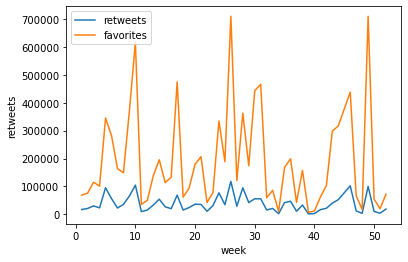

In [23]:
sns.lineplot(x = "week", y = "retweets", data = eng_weekly)
sns.lineplot(x = "week", y = "favorites", data = eng_weekly)
plt.legend(["retweets", "favorites"],loc="upper left")
plt.show()

# The level of social media activity vs level of engagement

Engagement on Twitter is measured by the number of retweets, follows, replies, favorites, and other people’s reactions to your tweets, including the clicks on the links and hashtags in those tweets. Your Twitter engagement rate is your engagement figure divided by the number of impressions on the tweet.

According to our 2022 Social Media Industry Benchmark Report, the overall median engagement rate on Twitter is 0.037%. This is the rate for brands across all industries, from fashion to nonprofits. On average, these brands are also posting about 5 times per week.

https://www.rivaliq.com/blog/good-engagement-rate-twitter/

In [24]:
eng_rate = df.withColumn('eng_rate', ((df['favorite_count'] + df['retweet_count'])/df['followers_count']))

In [25]:
eng_rate.limit(5).toPandas()

,name,screen_name,created_at,full_text,hashtags,lang,followers_count,friends_count,favourites_count,urls,symbols,retweet_count,favorite_count,post_created_at,eng_rate
0,SaaSLaunchr,SLaunchr,Mon Oct 18 09:24:09 +0000 2021,Sponsor #1: https://t.co/ixCQVKJZG5 After the ...,[],en,2,27,1,"[(pixelied.com, https://pixelied.com/, [12, 35...",[],0,0,2021-10-18 09:24:09,0.000000
1,JÆ,ijeislut,Mon Apr 04 10:47:40 +0000 2022,@tewfootprints #GoGreen #Recycle #Organic,"[([15, 23], GoGreen), ([24, 32], Recycle), ([3...",und,18,373,8321,[],[],0,0,2022-04-04 10:47:40,0.000000
2,Environment Matters,enviro_matters,Mon Apr 04 10:47:03 +0000 2022,@GillwallyO @irish_organic @peatyGHG This + if...,[],en,3160,2140,85172,[],[],0,2,2022-04-04 10:47:03,0.000633
3,Food and Beverages,FoodandBeverag8,Mon Apr 04 10:43:32 +0000 2022,Great River Organic Milling Great River Organi...,[],en,24,15,0,"[(ebay.com/itm/3940164472…, https://www.ebay.c...",[],0,0,2022-04-04 10:43:32,0.000000
4,Vegin' Out,VeginOut,Tue Sep 13 19:13:49 +0000 2022,🥕NEW Vegin' Out September 19th Vegan Delivery ...,"[([54, 60], Vegan), ([218, 226], govegan), ([2...",en,974,1928,62,"[(veginout.com/pages/vegin-ou…, https://www.ve...",[],0,0,2022-09-13 19:13:49,0.000000


In [26]:
eng_rate = eng_rate.withColumn('week', weekofyear('post_created_at'))

In [27]:
eng_rate_weekly = eng_rate.groupBy("week") \
                        .agg(avg("eng_rate").alias("eng_rate")) \
                        .sort("week", ascending = True)

In [28]:
eng_rate_weekly = eng_rate_weekly.toPandas()

22/11/21 16:58:44 WARN MemoryStore: Not enough space to cache rdd_21_10 in memory! (computed 3.9 MiB so far)
22/11/21 16:58:44 WARN MemoryStore: Not enough space to cache rdd_21_11 in memory! (computed 3.9 MiB so far)
22/11/21 16:58:44 WARN MemoryStore: Not enough space to cache rdd_21_15 in memory! (computed 3.9 MiB so far)


22/11/21 16:58:46 WARN MemoryStore: Not enough space to cache rdd_21_21 in memory! (computed 3.9 MiB so far)
22/11/21 16:58:46 WARN MemoryStore: Not enough space to cache rdd_21_23 in memory! (computed 3.9 MiB so far)


22/11/21 16:58:47 WARN MemoryStore: Not enough space to cache rdd_21_26 in memory! (computed 3.9 MiB so far)


22/11/21 16:58:48 WARN MemoryStore: Not enough space to cache rdd_21_31 in memory! (computed 3.9 MiB so far)


22/11/21 16:58:49 WARN MemoryStore: Not enough space to cache rdd_21_37 in memory! (computed 3.9 MiB so far)


22/11/21 16:58:51 WARN MemoryStore: Not enough space to cache rdd_21_43 in memory! (computed 3.9 MiB so far)


22/11/21 16:58:52 WARN MemoryStore: Not enough space to cache rdd_21_51 in memory! (computed 3.9 MiB so far)


22/11/21 16:58:53 WARN MemoryStore: Not enough space to cache rdd_21_54 in memory! (computed 3.9 MiB so far)


22/11/21 16:58:54 WARN MemoryStore: Not enough space to cache rdd_21_58 in memory! (computed 3.9 MiB so far)


22/11/21 16:58:54 WARN MemoryStore: Not enough space to cache rdd_21_63 in memory! (computed 3.9 MiB so far)


22/11/21 16:58:56 WARN MemoryStore: Not enough space to cache rdd_21_70 in memory! (computed 3.9 MiB so far)


22/11/21 16:58:57 WARN MemoryStore: Not enough space to cache rdd_21_75 in memory! (computed 3.9 MiB so far)
22/11/21 16:58:58 WARN MemoryStore: Not enough space to cache rdd_21_78 in memory! (computed 3.9 MiB so far)


22/11/21 16:59:02 WARN MemoryStore: Not enough space to cache rdd_21_99 in memory! (computed 3.9 MiB so far)


22/11/21 16:59:04 WARN MemoryStore: Not enough space to cache rdd_21_107 in memory! (computed 3.9 MiB so far)


22/11/21 16:59:06 WARN MemoryStore: Not enough space to cache rdd_21_116 in memory! (computed 3.9 MiB so far)


22/11/21 16:59:07 WARN MemoryStore: Not enough space to cache rdd_21_124 in memory! (computed 3.9 MiB so far)


22/11/21 16:59:09 WARN MemoryStore: Not enough space to cache rdd_21_133 in memory! (computed 3.9 MiB so far)


22/11/21 16:59:11 WARN MemoryStore: Not enough space to cache rdd_21_141 in memory! (computed 3.9 MiB so far)


22/11/21 16:59:12 WARN MemoryStore: Not enough space to cache rdd_21_145 in memory! (computed 3.9 MiB so far)
22/11/21 16:59:12 WARN MemoryStore: Not enough space to cache rdd_21_146 in memory! (computed 3.9 MiB so far)
22/11/21 16:59:12 WARN MemoryStore: Not enough space to cache rdd_21_149 in memory! (computed 3.9 MiB so far)


22/11/21 16:59:14 WARN MemoryStore: Not enough space to cache rdd_21_154 in memory! (computed 3.9 MiB so far)


22/11/21 16:59:14 WARN MemoryStore: Not enough space to cache rdd_21_157 in memory! (computed 3.9 MiB so far)


22/11/21 16:59:16 WARN MemoryStore: Not enough space to cache rdd_21_161 in memory! (computed 3.9 MiB so far)
22/11/21 16:59:16 WARN MemoryStore: Not enough space to cache rdd_21_162 in memory! (computed 3.9 MiB so far)


22/11/21 16:59:17 WARN MemoryStore: Not enough space to cache rdd_21_170 in memory! (computed 3.9 MiB so far)


22/11/21 16:59:19 WARN MemoryStore: Not enough space to cache rdd_21_178 in memory! (computed 3.9 MiB so far)


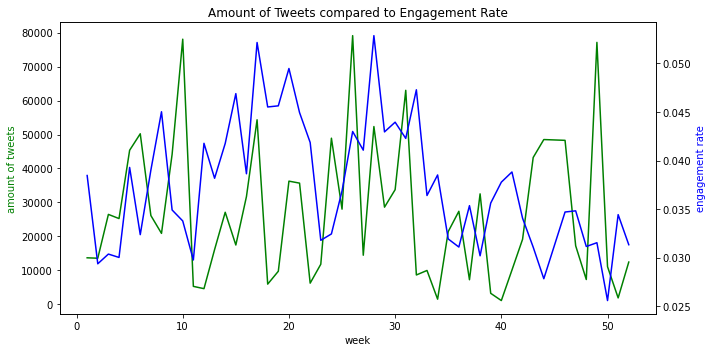

In [29]:
# plotting figures by creating axes object
# using subplots() function
fig, ax = plt.subplots(figsize = (10, 5))
plt.title('Amount of Tweets compared to Engagement Rate')
 
# using the twinx() for creating another
# axes object for secondary y-Axis
ax2 = ax.twinx()
ax.plot("week","freq", data = freq_week, color = 'g')
ax2.plot("week", "eng_rate", data = eng_rate_weekly, color = 'b')
 
# giving labels to the axises
ax.set_xlabel('week')
ax.set_ylabel('amount of tweets', color = 'g')
 
# secondary y-axis label
ax2.set_ylabel('engagement rate', color = 'b')
 
# defining display layout
plt.tight_layout()
 
# show plot
plt.show()

# The volume of influencer activity vs level of engagement 

In [36]:
biggest_users = df.groupBy("screen_name").agg(countDistinct("full_text"))

ConnectionRefusedError: [Errno 61] Connection refused

In [34]:
biggest_users.show()

[460.419s][warning][gc,alloc] Executor task launch worker for task 35.0 in stage 86.0 (TID 9347): Retried waiting for GCLocker too often allocating 13700 words
[460.419s][warning][gc,alloc] Executor task launch worker for task 32.0 in stage 86.0 (TID 9344): Retried waiting for GCLocker too often allocating 31799 words


22/11/21 17:01:10 WARN MemoryStore: Not enough space to cache rdd_21_49 in memory! (computed 3.9 MiB so far)
22/11/21 17:01:10 WARN MemoryStore: Not enough space to cache rdd_21_50 in memory! (computed 3.9 MiB so far)
22/11/21 17:01:10 WARN MemoryStore: Not enough space to cache rdd_21_51 in memory! (computed 3.9 MiB so far)
22/11/21 17:01:10 WARN MemoryStore: Not enough space to cache rdd_21_54 in memory! (computed 3.9 MiB so far)
22/11/21 17:01:10 WARN MemoryStore: Not enough space to cache rdd_21_55 in memory! (computed 3.9 MiB so far)


22/11/21 17:01:10 WARN MemoryStore: Not enough space to cache rdd_21_56 in memory! (computed 3.9 MiB so far)
22/11/21 17:01:10 WARN MemoryStore: Not enough space to cache rdd_21_52 in memory! (computed 3.9 MiB so far)
22/11/21 17:01:10 WARN MemoryStore: Not enough space to cache rdd_21_58 in memory! (computed 3.9 MiB so far)
22/11/21 17:01:11 WARN MemoryStore: Not enough space to cache rdd_21_61 in memory! (computed 3.9 MiB so far)
22/11/21 17:01:11 WARN MemoryStore: Not enough space to cache rdd_21_63 in memory! (computed 3.9 MiB so far)
22/11/21 17:01:11 WARN MemoryStore: Not enough space to cache rdd_21_64 in memory! (computed 3.9 MiB so far)
22/11/21 17:01:11 WARN MemoryStore: Not enough space to cache rdd_21_62 in memory! (computed 3.9 MiB so far)
22/11/21 17:01:11 WARN MemoryStore: Not enough space to cache rdd_21_65 in memory! (computed 3.9 MiB so far)


22/11/21 17:01:11 WARN MemoryStore: Not enough space to cache rdd_21_67 in memory! (computed 3.9 MiB so far)
22/11/21 17:01:11 WARN MemoryStore: Not enough space to cache rdd_21_68 in memory! (computed 3.9 MiB so far)
22/11/21 17:01:11 WARN MemoryStore: Not enough space to cache rdd_21_70 in memory! (computed 3.9 MiB so far)


22/11/21 17:01:11 WARN MemoryStore: Not enough space to cache rdd_21_72 in memory! (computed 3.9 MiB so far)
22/11/21 17:01:11 WARN MemoryStore: Not enough space to cache rdd_21_74 in memory! (computed 3.9 MiB so far)
22/11/21 17:01:11 WARN MemoryStore: Not enough space to cache rdd_21_75 in memory! (computed 3.9 MiB so far)
22/11/21 17:01:11 WARN MemoryStore: Not enough space to cache rdd_21_77 in memory! (computed 3.9 MiB so far)
22/11/21 17:01:11 WARN MemoryStore: Not enough space to cache rdd_21_76 in memory! (computed 3.9 MiB so far)
22/11/21 17:01:11 WARN MemoryStore: Not enough space to cache rdd_21_78 in memory! (computed 3.9 MiB so far)
22/11/21 17:01:11 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_21_83 in memory.
22/11/21 17:01:11 WARN MemoryStore: Not enough space to cache rdd_21_83 in memory! (computed 384.0 B so far)
22/11/21 17:01:11 WARN MemoryStore: Not enough space to cache rdd_21_82 in memory! (computed 3.9 MiB so

22/11/21 17:01:11 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_21_88 in memory.
22/11/21 17:01:11 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_21_86 in memory.
22/11/21 17:01:11 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_21_87 in memory.
22/11/21 17:01:11 WARN MemoryStore: Not enough space to cache rdd_21_87 in memory! (computed 384.0 B so far)
22/11/21 17:01:11 WARN MemoryStore: Not enough space to cache rdd_21_88 in memory! (computed 384.0 B so far)
22/11/21 17:01:11 WARN MemoryStore: Not enough space to cache rdd_21_86 in memory! (computed 384.0 B so far)
22/11/21 17:01:11 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_21_89 in memory.
22/11/21 17:01:11 WARN MemoryStore: Not enough space to cache rdd_21_89 in memory! (computed 384.0 B so far)
22/11/21 17:01:11 WARN Memor

22/11/21 17:01:11 WARN MemoryStore: Not enough space to cache rdd_21_94 in memory! (computed 3.9 MiB so far)
22/11/21 17:01:11 WARN MemoryStore: Not enough space to cache rdd_21_95 in memory! (computed 3.9 MiB so far)
22/11/21 17:01:11 WARN MemoryStore: Not enough space to cache rdd_21_97 in memory! (computed 3.9 MiB so far)
22/11/21 17:01:11 WARN MemoryStore: Not enough space to cache rdd_21_98 in memory! (computed 3.9 MiB so far)
22/11/21 17:01:11 WARN MemoryStore: Not enough space to cache rdd_21_96 in memory! (computed 3.9 MiB so far)
22/11/21 17:01:12 WARN MemoryStore: Not enough space to cache rdd_21_101 in memory! (computed 3.9 MiB so far)
22/11/21 17:01:12 WARN MemoryStore: Not enough space to cache rdd_21_102 in memory! (computed 3.9 MiB so far)
22/11/21 17:01:12 WARN MemoryStore: Not enough space to cache rdd_21_99 in memory! (computed 3.9 MiB so far)
22/11/21 17:01:12 WARN MemoryStore: Not enough space to cache rdd_21_100 in memory! (computed 3.9 MiB so far)


22/11/21 17:01:12 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_21_107 in memory.
22/11/21 17:01:12 WARN MemoryStore: Not enough space to cache rdd_21_106 in memory! (computed 3.9 MiB so far)
22/11/21 17:01:12 WARN MemoryStore: Not enough space to cache rdd_21_107 in memory! (computed 384.0 B so far)
22/11/21 17:01:12 WARN MemoryStore: Not enough space to cache rdd_21_109 in memory! (computed 3.9 MiB so far)
22/11/21 17:01:12 WARN MemoryStore: Not enough space to cache rdd_21_108 in memory! (computed 3.9 MiB so far)
22/11/21 17:01:12 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_21_110 in memory.
22/11/21 17:01:12 WARN MemoryStore: Not enough space to cache rdd_21_113 in memory! (computed 3.9 MiB so far)
22/11/21 17:01:12 WARN MemoryStore: Not enough space to cache rdd_21_111 in memory! (computed 3.9 MiB so far)
22/11/21 17:01:12 WARN MemoryStore: Not enough space to cache rdd_21_1

22/11/21 17:01:12 WARN MemoryStore: Not enough space to cache rdd_21_110 in memory! (computed 384.0 B so far)
22/11/21 17:01:12 ERROR Executor: Exception in task 111.0 in stage 86.0 (TID 9423)
java.lang.OutOfMemoryError: Java heap space
22/11/21 17:01:12 ERROR Executor: Exception in task 108.0 in stage 86.0 (TID 9420)
java.lang.OutOfMemoryError: Java heap space
22/11/21 17:01:12 ERROR Executor: Exception in task 113.0 in stage 86.0 (TID 9425)
java.lang.OutOfMemoryError: Java heap space
	at net.jpountz.lz4.LZ4BlockOutputStream.<init>(LZ4BlockOutputStream.java:102)
	at org.apache.spark.io.LZ4CompressionCodec.compressedOutputStream(CompressionCodec.scala:144)
	at org.apache.spark.serializer.SerializerManager.wrapForCompression(SerializerManager.scala:159)
	at org.apache.spark.serializer.SerializerManager.wrapStream(SerializerManager.scala:134)
	at org.apache.spark.storage.DiskBlockObjectWriter.open(DiskBlockObjectWriter.scala:163)
	at org.apache.spark.storage.DiskBlockObjectWriter.write(D

Py4JJavaError: An error occurred while calling o201.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 113 in stage 86.0 failed 1 times, most recent failure: Lost task 113.0 in stage 86.0 (TID 9425) (localhost executor driver): java.lang.OutOfMemoryError: Java heap space
	at net.jpountz.lz4.LZ4BlockOutputStream.<init>(LZ4BlockOutputStream.java:102)
	at org.apache.spark.io.LZ4CompressionCodec.compressedOutputStream(CompressionCodec.scala:144)
	at org.apache.spark.serializer.SerializerManager.wrapForCompression(SerializerManager.scala:159)
	at org.apache.spark.serializer.SerializerManager.wrapStream(SerializerManager.scala:134)
	at org.apache.spark.storage.DiskBlockObjectWriter.open(DiskBlockObjectWriter.scala:163)
	at org.apache.spark.storage.DiskBlockObjectWriter.write(DiskBlockObjectWriter.scala:306)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:171)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.executor.Executor$TaskRunner$$Lambda$1518/0x00000008014cb128.apply(Unknown Source)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:833)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2672)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2608)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2607)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2607)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1182)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1182)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2860)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2791)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: java.lang.OutOfMemoryError: Java heap space
	at net.jpountz.lz4.LZ4BlockOutputStream.<init>(LZ4BlockOutputStream.java:102)
	at org.apache.spark.io.LZ4CompressionCodec.compressedOutputStream(CompressionCodec.scala:144)
	at org.apache.spark.serializer.SerializerManager.wrapForCompression(SerializerManager.scala:159)
	at org.apache.spark.serializer.SerializerManager.wrapStream(SerializerManager.scala:134)
	at org.apache.spark.storage.DiskBlockObjectWriter.open(DiskBlockObjectWriter.scala:163)
	at org.apache.spark.storage.DiskBlockObjectWriter.write(DiskBlockObjectWriter.scala:306)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:171)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:99)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:52)
	at org.apache.spark.scheduler.Task.run(Task.scala:136)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:548)
	at org.apache.spark.executor.Executor$TaskRunner$$Lambda$1518/0x00000008014cb128.apply(Unknown Source)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1504)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:551)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:833)
